## imports e declarações

In [1]:
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from matplotlib.pyplot import *

# Preparação, limpeza e agregação

## preparação e limpeza do dataset 1

In [2]:
def repModalidade(data):
    data.reset_index(drop=True, inplace=True)
    if('modalidade' not in data.columns):
            data["modalidade"]='Não especificado'
    for i in range(len(data)):
        if(data.loc[i,('curso')].startswith('Licenciatura Em ')):
            data.loc[i,('modalidade')]='Licenciatura Plena'
            data.loc[i,('curso')]=data['curso'][i][16:]
        elif(data.loc[i,('curso')].endswith(' - Noturno')):
            data.loc[i,('curso')]=data['curso'][i][:-10]
        elif(data.loc[i,('curso')].endswith(' - Bacharelado')):
            data.loc[i,('modalidade')]='Bacharelado'
            data.loc[i,('curso')]=data['curso'][i][:-14]
        elif(data.loc[i,('curso')].endswith(' - Licenciatura Plena (Cod.111.Uni)')):
            data.loc[i,('modalidade')]='Licenciatura Plena'
            data.loc[i,('curso')]=data['curso'][i][:-14]
        else:
            data.loc[i,('modalidade')]='Bacharelado'
            
def cleardb1(data):
    data.columns = data.loc[0]
    data.drop(data.index[:1], inplace=True)
    data.drop(data.index[-1], inplace=True)
    data["Campus"].fillna(method='ffill', inplace=True)
    data.rename({"NOME_CURSO": "curso", "Campus": "campus"}, axis=1, inplace=True)
    data.curso = data.curso.str.title()
    data["turno"]='Não especificado'
    col = ["Abandono","Cancelamento","Classificado e Não Matriculado","Desligamento","Transferido"]
    for i in col:
        if i not in data.columns:
            data[i] = np.nan
        data[i].fillna(0, inplace=True)

    data.dropna(axis=1, inplace=True)
    
    s=data['curso']
    s[s.str.startswith('Curso De ')]=s[s.str.startswith('Curso De ')].str[9:]
    data['curso']=s
    data['curso']=data['curso'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    repModalidade(data)
    data.reset_index(drop=True, inplace=True)

    
#carregando as databases e limpando com os metodos definidos anteriormente
d061 = pd.read_csv("./data/evasao - 061.csv", encoding = "utf-8")
cleardb1(d061)
d061.drop(columns=["Nº de alunos"], inplace=True)

d062 = pd.read_csv("./data/evasao - 062.csv", encoding = "utf-8")
cleardb1(d062)
d062.drop(columns=["Nº de alunos"], inplace=True)

d071 = pd.read_csv("./data/evasao - 071.csv", encoding = "utf-8")
cleardb1(d071)
d071.drop(columns=["Nº alunos"], inplace=True)

d072 = pd.read_csv("./data/evasao - 072.csv", encoding = "utf-8")
cleardb1(d072)
d072.drop(columns=["Nº de alunos"], inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## preparação e limpeza do dataset 2

In [3]:
def cleardb2(data, lastline):
    data.columns = data.loc[1]
    data.drop(data.index[:2], inplace=True)
    data.drop(data.index[lastline], inplace=True)
    data.drop(data.loc[data.NOME_CURSO=='Regime Especial De Graduacao'].index, inplace=True)
    
    data["NOME_CURSO"].fillna(method='ffill', inplace=True)
    
    if ('Campus' in data.columns):
        data["Campus"].fillna(method='ffill', inplace=True)

    data.dropna(1, inplace=True)
    data.reset_index(drop=True, inplace=True)
    data = split(data)
    data = pivoting(data)
    data.curso = data.curso.str.title()
    s=data['curso']
    s[s.str.startswith('Curso De ')]=s[s.str.startswith('Curso De ')].str[9:]
    data['curso']=s
    data['curso']=data['curso'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    repModalidade(data)
    return data
    
def split(data):
    ocorrencia = data[["Ocorrência/forma de evasão"]]
    ocorrencia = pd.DataFrame(ocorrencia["Ocorrência/forma de evasão"].str.split("=").tolist())
    data = pd.concat([data, ocorrencia], axis=1, join_axes=[data.index])
    
    data.drop(columns=["Ocorrência/forma de evasão"], inplace=True)
    data.rename({"NOME_CURSO": "curso", 0:"tipo", 1:"quantidade"}, axis=1, inplace=True)
    data.quantidade = data.quantidade.apply(pd.to_numeric)
    return data

def pivoting(data):
    data.dropna(inplace=True)
    data1 = data.pivot(index="curso", columns='tipo', values="quantidade")
    data1.fillna(0, inplace=True)
    data1.reset_index(inplace=True)
    data1.dropna(axis=0, inplace=True)
    return data1

In [4]:
#carregando as databases e limpando com os metodos definidos anteriormente
d081 = pd.read_csv("./data/evasao - 081.csv", encoding = "utf-8")
d081 = cleardb2(d081,-4)

d082 = pd.read_csv("./data/evasao - 082.csv", encoding = "utf-8")
d082 = cleardb2(d082, -5)

d091 = pd.read_csv("./data/evasao - 091.csv", encoding = "utf-8")
d091 = cleardb2(d091, -8)

d092 = pd.read_csv("./data/evasao - 092.csv", encoding = "utf-8")
d092 = cleardb2(d092, -6)

d101 = pd.read_csv("./data/evasao - 101.csv", encoding = "utf-8")
d101 = cleardb2(d101, -8)

d102 = pd.read_csv("./data/evasao - 102.csv", encoding = "utf-8")
d102 = cleardb2(d102,-7)

d111 = pd.read_csv("./data/evasao - 111.csv", encoding = "utf-8")
d111 = cleardb2(d111,-5)

    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## limpeza e preparação do dataset 3

In [5]:
a2016m01 = pd.read_csv("data/nAlunosPorMes/a2016m01.csv", encoding = "ISO-8859-1")
a2016m02 = pd.read_csv("data/nAlunosPorMes/a2016m02.csv", encoding = "ISO-8859-1")
a2016m03 = pd.read_csv("data/nAlunosPorMes/a2016m03.csv", encoding = "ISO-8859-1")
a2016m04 = pd.read_csv("data/nAlunosPorMes/a2016m04.csv", encoding = "ISO-8859-1")
a2016m05 = pd.read_csv("data/nAlunosPorMes/a2016m05.csv", encoding = "ISO-8859-1")
a2016m06 = pd.read_csv("data/nAlunosPorMes/a2016m06.csv", encoding = "ISO-8859-1")
a2016m07 = pd.read_csv("data/nAlunosPorMes/a2016m07.csv", encoding = "ISO-8859-1")
a2016m08 = pd.read_csv("data/nAlunosPorMes/a2016m08.csv", encoding = "ISO-8859-1")
a2016m10 = pd.read_csv("data/nAlunosPorMes/a2016m10.csv", encoding = "ISO-8859-1")
a2016m11 = pd.read_csv("data/nAlunosPorMes/a2016m11.csv", delimiter=';', encoding = "ISO-8859-1")
a2016m12 = pd.read_csv("data/nAlunosPorMes/a2016m12.csv", delimiter=';', encoding = "ISO-8859-1")

a2017m01 = pd.read_csv("data/nAlunosPorMes/a2017m01.csv", delimiter=';', encoding = "ISO-8859-1")
a2017m02 = pd.read_csv("data/nAlunosPorMes/a2017m02.csv", delimiter=';', encoding = "ISO-8859-1")
a2017m03 = pd.read_csv("data/nAlunosPorMes/a2017m03.csv", delimiter=';', encoding = "ISO-8859-1")
a2017m04 = pd.read_csv("data/nAlunosPorMes/a2017m04.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m05 = pd.read_csv("data/nAlunosPorMes/a2017m05.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m07 = pd.read_csv("data/nAlunosPorMes/a2017m07.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m08 = pd.read_csv("data/nAlunosPorMes/a2017m08.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m09 = pd.read_csv("data/nAlunosPorMes/a2017m09.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m11 = pd.read_csv("data/nAlunosPorMes/a2017m11.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m12 = pd.read_csv("data/nAlunosPorMes/a2017m12.csv", delimiter=',', encoding = "ISO-8859-1")

a2018m01 = pd.read_csv("data/nAlunosPorMes/a2018m01.csv", delimiter=',', encoding = "ISO-8859-1")
a2018m02 = pd.read_csv("data/nAlunosPorMes/a2018m02.csv", delimiter=',', encoding = "ISO-8859-1")
a2018m03 = pd.read_csv("data/nAlunosPorMes/a2018m03.csv", delimiter=',', encoding = "ISO-8859-1")
a2018m04 = pd.read_csv("data/nAlunosPorMes/a2018m04.csv", delimiter=',', encoding = "ISO-8859-1")

#colocando as referencias da lista para fazer uma primeira limpeza
datasets3=[a2016m01,a2016m02, a2016m03, a2016m04, a2016m05, a2016m06, a2016m07, a2016m08, a2016m10, a2016m11, a2016m12,
          a2017m01, a2017m02, a2017m03,a2017m04, a2017m05, a2017m07, a2017m08, a2017m09, a2017m11, a2017m12,
          a2018m01,a2018m02,a2018m03,a2018m04]

#constantes para jogar as tabelas em dataframes
a=['nome do curso','campus', 'nível', 'turno', 'modalidade',  'alunos matriculados']
b=['nome do curso', 'campus', 'nível', 'turno', 'modalidade']

In [6]:
find=['Letras -  Com Habilitação Em Lingua Portuguesa E Respectivas Literaturas', 
      'Letras -  Com Habilitação Em Língua Portuguesa E Respectivas Literaturas',
     'Geografia Licenciatura', 'Licenciatura Em Educação Física', 'Licenciatura Em Pedagogia', 
     'Engenharia Em Agrimensura']
repl=['Letras Português']*2+['Licenciatura Em Geografia','Educação Física', 'Pedagogia', 'Engenharia De Agrimensura']

for i in range (len(datasets3)):
    datasets3[i]['nome do curso']=datasets3[i]['nome do curso'].str.title()
    datasets3[i]['nome do curso']=datasets3[i]['nome do curso'].str.strip()
    for j in range (len(find)):
        datasets3[i]['nome do curso']=datasets3[i]['nome do curso'].str.replace(find[j],repl[j])
        
datasets3=None

In [7]:
#Datasets 2016-01 a 2016-12
df1602=pd.merge(a2016m01[a],a2016m02[a], how='outer', on=b, suffixes=(' em 16-01',' em 16-02'))
df1603=pd.merge(df1602,a2016m03[a], how='outer', on=b)
df1604=pd.merge(df1603,a2016m04[a], how='outer', on=b, suffixes=(' em 16-03',' em 16-04'))
df1605=pd.merge(df1604,a2016m05[a], how='outer', on=b)
df1606=pd.merge(df1605,a2016m06[a], how='outer', on=b, suffixes=(' em 16-05',' em 16-06'))
df1607=pd.merge(df1606,a2016m07[a], how='outer', on=b)
df1608=pd.merge(df1607,a2016m08[a], how='outer', on=b, suffixes=(' em 16-07',' em 16-08'))
df1610=pd.merge(df1608,a2016m10[a], how='outer', on=b)
df1611=pd.merge(df1610,a2016m11[a], how='outer', on=b, suffixes=(' em 16-10',' em 16-11'))
df16final=pd.merge(df1611,a2016m11[a], how='outer', on=b)

df16final.drop(df16final.loc[df16final.nível!='Graduação'].index, inplace=True)
df16final.rename({'alunos matriculados': 'alunos matriculados em 16-12'}, axis=1, inplace=True)
df16final.sort_values(by=['campus', 'nome do curso'], inplace=True, ascending=True)
df16final.reset_index(drop=True, inplace=True)

In [8]:
#Datasets 2017-01 a 2017-12
df1702=pd.merge(a2017m01[a],a2017m02[a], how='outer', on=b, suffixes=(' em 17-01',' em 17-02'))
df1703=pd.merge(df1702,a2017m03[a], how='outer', on=b)
df1704=pd.merge(df1703,a2017m04[a], how='outer', on=b, suffixes=(' em 17-03',' em 17-04'))
df1705=pd.merge(df1704,a2017m05[a], how='outer', on=b)
df1707=pd.merge(df1705,a2017m07[a], how='outer', on=b, suffixes=(' em 17-05',' em 17-07'))
df1708=pd.merge(df1707,a2017m08[a], how='outer', on=b)
df1709=pd.merge(df1708,a2017m09[a], how='outer', on=b, suffixes=(' em 17-08',' em 17-09'))
df1711=pd.merge(df1709,a2017m11[a], how='outer', on=b)
df17final=pd.merge(df1711,a2017m12[a], how='outer', on=b, suffixes=(' em 17-11',' em 17-12'))

df17final.drop(df17final.loc[df17final.nível!='Graduação'].index, inplace=True)
df17final.reset_index(drop=True, inplace=True)
df17final.sort_values(by=['campus', 'nome do curso'], inplace=True)

In [9]:
#Datasets 2018-01 a 2018-04
df1802=pd.merge(a2018m01[a],a2018m02[a], how='outer', on=b, suffixes=(' em 18-01',' em 18-02'))
df1803=pd.merge(df1802,a2018m03[a], how='outer', on=b)
df18final=pd.merge(df1803,a2018m04[a], how='outer', on=b, suffixes=(' em 18-03',' em 18-04'))

df18final.drop(df18final.loc[df18final.nível!='Graduação'].index, inplace=True)
df18final.reset_index(drop=True, inplace=True)

In [10]:
df1617=pd.merge(df16final,df17final, how='outer', on=b)
df1618=pd.merge(df1617,df18final, how='outer', on=b)

In [11]:
#será considero que o primeiro semestre do ano comece em Abril (pois é quando são contabilizados os alunos matriculados 
#no mes de fevereiro e Março) e termine em Julho (mes onde são contabilidados os alunos matriculados no final do periodo letivo) e que o segundo semestre comece em Agosto(mês em que
# as ferias terminam e ocorrem as transferencias) e termine em Fevereiro (utlimo mes antes da contabilização das inscrições
#através do enem)
#O nível de precisão será menor do que das tabelas de antes de 2012, já que podem ter saído alunos nos meses em que novos 
# entram, assim, mascarando a quantidade de abandonos e de inscrições
#o calculo para ver a quantidade de desistencia de cada semestre será: 
#    quantidade de alunos no mês de inicio do semestre - quantidade de alunos no mês de termino do semestre.
# Então, para o primeiro semestre sera: Qntdd em Março - Qntdd em Julho
# E para o segundo semestre será: Qntdd em Agosto - Qntdd em Fevereiro
# Como os dados começam em Novembro de 2015 e terminam em Abril de 2018, o calculo do segundo semestre de 2015 será começado
# a partir de Novembro, e o fim do primeiro semestre de 2018 será em Abril, pois é até onde temos os dados

def dif(df1, mes1, mes2):
    retorno=df1.copy()
    pattern='alunos matriculados em '
    col1=pattern+mes1
    col2=pattern+mes2
    retorno['diff']=retorno[col1]-retorno[col2]
    return retorno[['nome do curso', 'campus','turno','modalidade', col1, col2, 'diff']]

def addcols(df):
    df['classificado e não matriculado']=0
    df['cancelamento']=0
    df['desligamento']=0
    df['falecimento']=0
    df['transferência']=0
    return df
    
def cleardb3(df, mes1, mes2):
    ab=dif(df, mes1, mes2)
    ab=ab[[c for c in ab.columns if 'alunos' not in c]]
    ab.rename({'diff': 'abandono'}, axis=1, inplace=True)
    ab.rename({'nome do curso': 'curso'}, axis=1, inplace=True)
    ab['abandono'].fillna(0, inplace=True)
    
    s=ab['abandono']
    s[s<0]=0
    ab['abandono']=s
    
    ab['campus'] = ab['campus'].str[7:]
    addcols(ab)
    ab.drop(ab.loc[ab.curso=='Aluno Em Regime Especial De Graduacao'].index, inplace=True)
    ab.reset_index(drop=True, inplace=True)
    ab['curso']=ab['curso'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    return ab

df1=cleardb3(df1618,'16-04','16-07')
df2=cleardb3(df1618,'16-08','17-02')
df3=cleardb3(df1618,'17-04','17-07')
df4=cleardb3(df1618,'17-08','18-02')
df5=cleardb3(df1618,'18-03','18-04')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## finalizando a limpesa dos datasets agregando o campus na tabela dos cursos

In [12]:
datasetsSeparated = [d061,d062,d071,d072,d081,d082,d091,d092,d101,d102,d111] 
aa={}

def takecampus(df, referencia1=df5, referencia2=d072):
    def makedict(df):
        return dict(zip(df['curso'],df['campus']))
    if(aa=={}):
        aa.update(makedict(referencia1))
        aa.update(makedict(referencia2))
    if('campus' not in df.columns):
        df['campus']=df['curso'].map(aa)
    else:
        aa.update(makedict(df))
    s=df['campus']
    s[s.isnull()]='Não Especificado'
    #print(s[s.isnull()])
    df['campus']=s

for i in range(len(datasetsSeparated)):
    datasetsSeparated[i].columns = datasetsSeparated[i].columns.str.lower()
    takecampus(datasetsSeparated[i], df5)
    datasetsSeparated[i].sort_values(by="campus", inplace=True)

datasetsSeparated += [df1,df2,df3,df4,df5]
for i in range(len(datasetsSeparated)):
    if("transferência" in datasetsSeparated[i]):
        if("transferência interna" in datasetsSeparated[i]):
            datasetsSeparated[i]["transferência"] += datasetsSeparated[i]["transferência interna"]
            datasetsSeparated[i].drop("transferência interna", axis=1, inplace=True)
        if("transferido" in datasetsSeparated[i]):
            datasetsSeparated[i]["transferência"] += datasetsSeparated[i]["transferido"]
            datasetsSeparated[i].drop("transferido", axis=1, inplace=True)
    else:
        datasetsSeparated[i].rename(columns={"transferido": "transferência"},inplace=True)
    if("classificado e não matriculado" in datasetsSeparated[i]):
        if("sem matrícula" in datasetsSeparated[i]):
            datasetsSeparated[i]["classificado e não matriculado"] += datasetsSeparated[i]["sem matrícula"]
            datasetsSeparated[i].drop("sem matrícula", axis=1, inplace=True)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## agregando todas as tabelas por semestre

In [13]:
keys = ["06.1", "06.2", "07.1", "07.2", "08.1", "08.2", "09.1", "09.2", "10.1", "10.2", "11.1", "16.1", "16.2", "17.1", "17.2", "18.1"]
datasets = pd.concat(datasetsSeparated, keys=keys)
datasets = datasets.fillna(0)
datasets = datasets.apply(pd.to_numeric, errors='ignore')
datasets.index.name = "semestre"
datasets.index.names=['semestres','']

# Respostas para as perguntas:

### Qual as cidades com o maior indice de evasões?

As duas cidades com maior indice de evasão são Bagé com 25.11% e Alegrete com 17.26% do total de evasões do primeiro semestre de 2006 até o primeiro semestre de 2018(desconciderando o intevalo entre 2011.2 e 2015.2 por falta do dataset nesse periodo), como pode ser visto a baixo, na tabela e no grafico.

In [14]:
cidades = datasets.groupby("campus").sum().sum(axis=1).sort_values(ascending=False)
cidades

campus
Bagé                     1780.0
Alegrete                  960.0
Uruguaiana                877.0
São Borja                 731.0
Santana do Livramento     652.0
Jaguarão                  594.0
Itaqui                    589.0
São Gabriel               575.0
Dom Pedrito               491.0
Caçapava do Sul           401.0
Não Especificado          306.0
dtype: float64

In [15]:
cidades.sum()

7956.0

<BarContainer object of 11 artists>

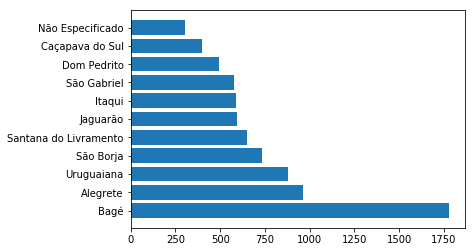

In [16]:
barh(cidades.index, cidades.values)

In [17]:
cidades.Bagé/cidades.sum()*100

22.373051784816493

In [18]:
cidades.Alegrete/cidades.sum()*100

12.066365007541478

## Comparação entre as categorias de evasão

In [19]:
categorias = ["abandono", "cancelamento", "classificado e não matriculado", "desligamento","falecimento"]
cat = datasets[categorias]
cat = cat.loc[["06.1", "06.2", "07.1", "07.2", "08.1", "08.2", "09.1", "09.2", "10.1", "10.2", "11.1"]].sum()

In [20]:
cat
#abandono                          2178.0
#cancelamento                       348.0
#classificado e não matriculado      85.0
#desligamento                        59.0
#falecimento                          6.0 


abandono                          2178.0
cancelamento                       348.0
classificado e não matriculado      85.0
desligamento                        59.0
falecimento                          6.0
dtype: float64

<BarContainer object of 5 artists>

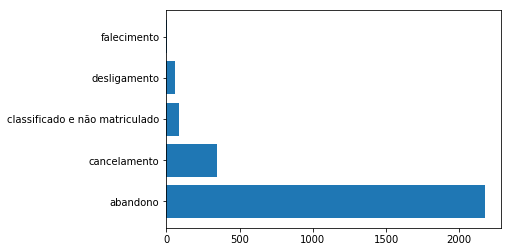

In [21]:
barh(cat.index, cat.values)

In [22]:
cat.loc["abandono"]/cat.sum()*100

81.39013452914799

## Curso com maior numero de evasão

In [23]:
cur_group=datasets.groupby('curso')
cur_group.sum().transpose().sum().sort_values(ascending=False).head(10)



curso
Administracao               299.0
Matematica                  299.0
Engenharia Civil            242.0
Engenharia De Computacao    229.0
Engenharia De Producao      226.0
Ciencia Da Computacao       210.0
Engenharia Quimica          179.0
Farmacia                    176.0
Ciencias Da Natureza        168.0
Engenharia Florestal        167.0
dtype: float64